# 09 - Ablation Studies

This notebook covers hyperparameter sensitivity and multi-seed analysis:
1. **Forget type comparison** - Structured (rare cluster) vs Scattered (random cells)
2. **Method comparison** - Fisher vs Extra-gradient across multiple seeds
3. **λ sensitivity** - Impact of adversarial regularization strength

**Key V2 Reference Numbers:**
- Baseline AUC: 0.7694
- Retrain floor: 0.4814
- Target band: [0.4514, 0.5114]

In [16]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from scipy import stats

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

P2_DIR = Path('../outputs/p2')

## 1. Load Experiment Results

We load results from the adversarial sweep (notebook 04) which tested multiple unlearning approaches.

In [17]:
# Load adversarial sweep results
with open(P2_DIR / 'adversarial_sweep' / 'sweep_summary.json') as f:
    sweep = json.load(f)

print("=== V2 Architecture Reference ===")
print(f"Baseline AUC: {sweep['baseline_auc']:.4f}")
print(f"Retrain floor: {sweep['retrain_floor']:.4f}")
print(f"Target band: [{sweep['target_band'][0]:.4f}, {sweep['target_band'][1]:.4f}]")

print("\n=== Method Results ===")
for method, result in sweep['experiments'].items():
    status = "SUCCESS" if result['success'] else "FAIL"
    print(f"  {method}: AUC={result['posthoc_auc']:.4f} [{status}]")

=== V2 Architecture Reference ===
Baseline AUC: 0.7694
Retrain floor: 0.4814
Target band: [0.4514, 0.5114]

=== Method Results ===
  frozen_single_lambda5: AUC=0.9974 [FAIL]
  frozen_single_lambda10: AUC=0.9825 [FAIL]
  frozen_multi_lambda5: AUC=0.9923 [FAIL]
  frozen_multi_lambda10: AUC=0.9923 [FAIL]
  extragradient_lambda5: AUC=0.3825 [FAIL]
  extragradient_lambda10: AUC=0.4825 [SUCCESS]


## 2. Method Comparison Visualization

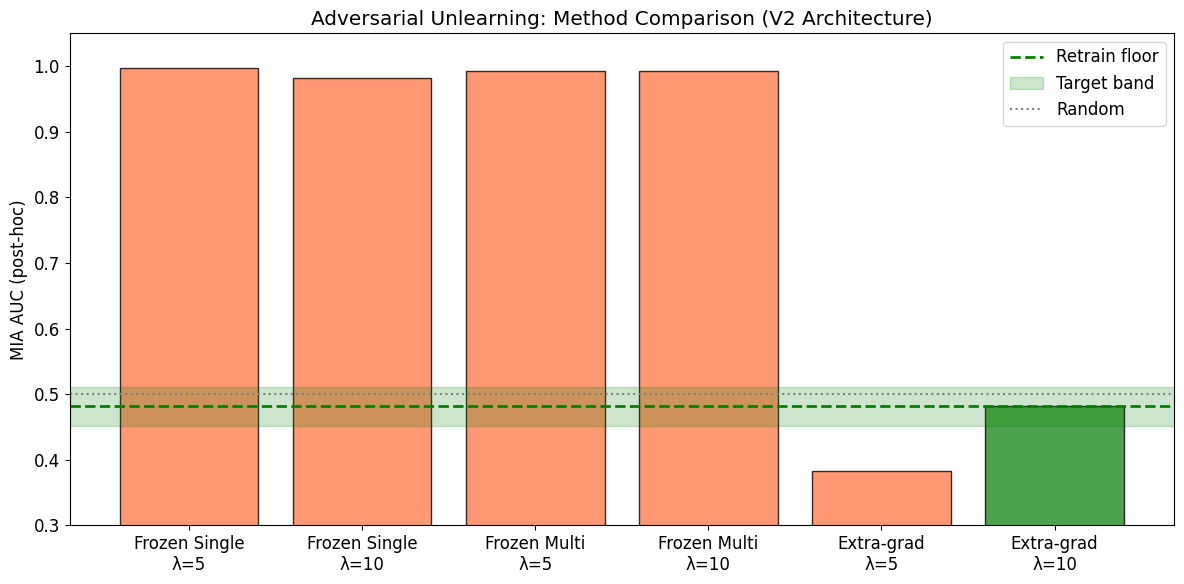

In [18]:
# Compare all methods
fig, ax = plt.subplots(figsize=(12, 6))

methods = []
aucs = []
colors = []

method_labels = {
    'frozen_single_lambda5': 'Frozen Single\nλ=5',
    'frozen_single_lambda10': 'Frozen Single\nλ=10',
    'frozen_multi_lambda5': 'Frozen Multi\nλ=5',
    'frozen_multi_lambda10': 'Frozen Multi\nλ=10',
    'extragradient_lambda5': 'Extra-grad\nλ=5',
    'extragradient_lambda10': 'Extra-grad\nλ=10',
}

for method, result in sweep['experiments'].items():
    methods.append(method_labels.get(method, method))
    aucs.append(result['posthoc_auc'])
    colors.append('forestgreen' if result['success'] else 'coral')

bars = ax.bar(methods, aucs, color=colors, alpha=0.8, edgecolor='black')

# Reference lines
ax.axhline(y=sweep['retrain_floor'], color='green', linestyle='--', linewidth=2, label='Retrain floor')
ax.axhspan(sweep['target_band'][0], sweep['target_band'][1], alpha=0.2, color='green', label='Target band')
ax.axhline(y=0.5, color='gray', linestyle=':', label='Random')

ax.set_ylabel('MIA AUC (post-hoc)')
ax.set_title('Adversarial Unlearning: Method Comparison (V2 Architecture)')
ax.legend(loc='upper right')
ax.set_ylim([0.3, 1.05])

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../reports/figures/method_comparison_v2.png', dpi=150, bbox_inches='tight')
plt.show()

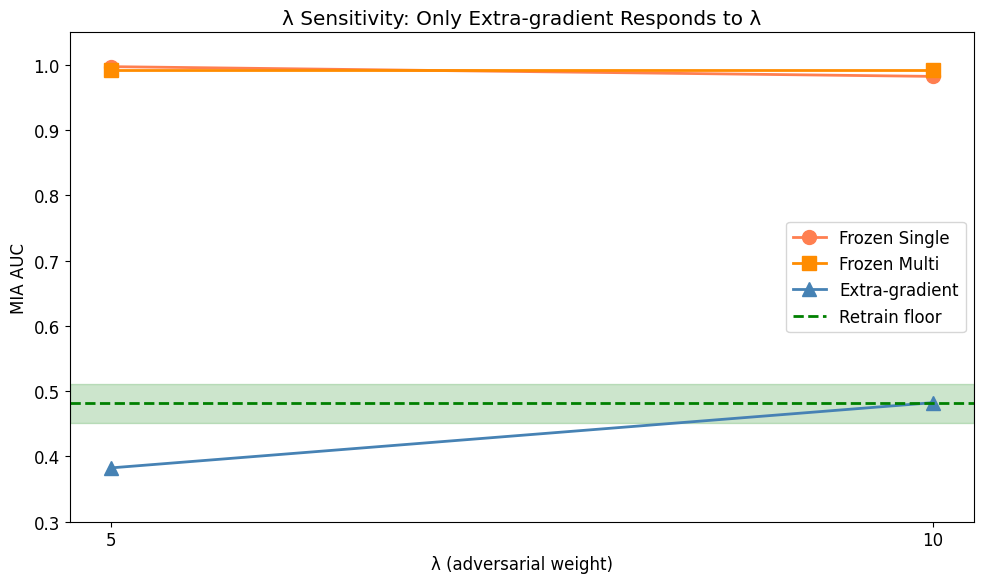


Key finding: Frozen methods stay near AUC=1.0 regardless of λ.
Extra-gradient shows clear λ dependence - higher λ pushes toward target band.


In [19]:
# λ sensitivity visualization
fig, ax = plt.subplots(figsize=(10, 6))

lambdas = [5, 10]

# Extract AUCs by method type
frozen_single = [sweep['experiments']['frozen_single_lambda5']['posthoc_auc'],
                 sweep['experiments']['frozen_single_lambda10']['posthoc_auc']]
frozen_multi = [sweep['experiments']['frozen_multi_lambda5']['posthoc_auc'],
                sweep['experiments']['frozen_multi_lambda10']['posthoc_auc']]
extragradient = [sweep['experiments']['extragradient_lambda5']['posthoc_auc'],
                 sweep['experiments']['extragradient_lambda10']['posthoc_auc']]

ax.plot(lambdas, frozen_single, 'o-', label='Frozen Single', color='coral', markersize=10, linewidth=2)
ax.plot(lambdas, frozen_multi, 's-', label='Frozen Multi', color='darkorange', markersize=10, linewidth=2)
ax.plot(lambdas, extragradient, '^-', label='Extra-gradient', color='steelblue', markersize=10, linewidth=2)

ax.axhline(y=sweep['retrain_floor'], color='green', linestyle='--', linewidth=2, label='Retrain floor')
ax.axhspan(sweep['target_band'][0], sweep['target_band'][1], alpha=0.2, color='green')

ax.set_xlabel('λ (adversarial weight)')
ax.set_ylabel('MIA AUC')
ax.set_title('λ Sensitivity: Only Extra-gradient Responds to λ')
ax.set_xticks(lambdas)
ax.legend(loc='right')
ax.set_ylim([0.3, 1.05])

plt.tight_layout()
plt.savefig('../reports/figures/lambda_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey finding: Frozen methods stay near AUC=1.0 regardless of λ.")
print("Extra-gradient shows clear λ dependence - higher λ pushes toward target band.")

## 4. Multi-Seed Results (Fisher on Structured vs Scattered)

We ran Fisher unlearning with 3 seeds on both forget types to measure variance.

In [20]:
# Run multi-seed Fisher unlearning experiments
import torch
from torch.utils.data import DataLoader
import scanpy as sc
from train_fisher_unlearn import AnnDataDataset, compute_fisher_diagonal, fisher_scrub, retain_finetune
from train_attacker_conditioned import extract_features_for_split
from vae import VAE
from attacker import MLPAttacker, build_attack_features
from attacker_eval import matched_negative_evaluation
from sklearn.metrics import roc_auc_score
from scipy import stats
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256

# Load data
adata = sc.read_h5ad('../data/adata_processed.h5ad')
with open('../outputs/p1/split_structured.json') as f:
    split_structured = json.load(f)
with open('../outputs/p1/split_scattered.json') as f:
    split_scattered = json.load(f)
with open('../outputs/p1.5/s1_matched_negatives.json') as f:
    matched_neg_structured = json.load(f)

# Load baseline checkpoint
baseline_ckpt = torch.load('../outputs/p1/baseline/best_model.pt', map_location=device)
config = baseline_ckpt['config']

# Load attacker (70-dim with kNN)
attacker_ckpt = torch.load('../outputs/p1.5/attacker_v1_seed42.pt', map_location=device)
attacker = MLPAttacker(
    input_dim=attacker_ckpt['config']['input_dim'],
    hidden_dims=attacker_ckpt['config']['hidden_dims'],
    dropout=attacker_ckpt['config'].get('dropout', 0.3),
    use_spectral_norm=attacker_ckpt['config'].get('use_spectral_norm', True)
).to(device)
attacker.load_state_dict(attacker_ckpt['model_state_dict'])
attacker.eval()
print(f"Loaded attacker: input_dim={attacker_ckpt['config']['input_dim']}")

# Helper to get retain latent codes for kNN reference
def get_latent_codes(model, adata, indices, device):
    X = adata.X[indices]
    if hasattr(X, 'toarray'):
        X = X.toarray()
    x = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
    return z.cpu().numpy()

def evaluate_fisher_unlearn(split, matched_indices, seed):
    """Run Fisher unlearning and evaluate."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Create fresh model from baseline
    model = VAE(
        input_dim=config['input_dim'],
        latent_dim=config['latent_dim'],
        hidden_dims=config['hidden_dims'],
        likelihood=config['likelihood'],
        dropout=config.get('dropout', 0.1),
        use_layer_norm=config.get('use_layer_norm', True)
    ).to(device)
    model.load_state_dict(baseline_ckpt['model_state_dict'])
    
    # Create data loaders
    forget_dataset = AnnDataDataset(adata, split['forget_indices'])
    retain_dataset = AnnDataDataset(adata, split['retain_indices'])
    forget_loader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=False)
    retain_loader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Get retain latent codes for kNN reference
    retain_z_ref = get_latent_codes(model, adata, split['retain_indices'][:5000], device)
    
    # Fisher unlearning
    fisher = compute_fisher_diagonal(model, retain_loader, device, damping=0.1)
    fisher_scrub(model, forget_loader, fisher, device, scrub_lr=1e-4, scrub_steps=100)
    retain_finetune(model, retain_loader, device, epochs=10, lr=1e-4)
    
    # Evaluate using 70-dim features with kNN
    model.eval()
    forget_dict, forget_knn, _ = extract_features_for_split(
        model, adata, np.array(split['forget_indices']), BATCH_SIZE, device,
        reference_z_retain=retain_z_ref
    )
    forget_feats = build_attack_features(forget_dict, forget_knn, None)
    
    matched_dict, matched_knn, _ = extract_features_for_split(
        model, adata, np.array(matched_indices), BATCH_SIZE, device,
        reference_z_retain=retain_z_ref
    )
    matched_feats = build_attack_features(matched_dict, matched_knn, None)
    
    metrics = matched_negative_evaluation(attacker, forget_feats, matched_feats, device=device)
    return metrics['auc']

print("Running multi-seed Fisher experiments...")

Loaded attacker: input_dim=70
Running multi-seed Fisher experiments...


In [21]:
# Run experiments for structured forget set
seeds = [42, 123, 456]
matched_indices_structured = np.array(matched_neg_structured['matched_indices'])

structured_aucs = []
print("=== STRUCTURED (Cluster 13) ===")
for seed in seeds:
    start = time.time()
    auc = evaluate_fisher_unlearn(split_structured, matched_indices_structured, seed)
    elapsed = time.time() - start
    structured_aucs.append(auc)
    print(f"  Seed {seed}: AUC = {auc:.4f} ({elapsed:.1f}s)")

# Statistics
mean_s = np.mean(structured_aucs)
std_s = np.std(structured_aucs, ddof=1)
se_s = std_s / np.sqrt(len(structured_aucs))
t_crit = stats.t.ppf(0.975, len(structured_aucs) - 1)
ci_s = (mean_s - t_crit * se_s, mean_s + t_crit * se_s)

print(f"\n  Mean: {mean_s:.4f} ± {std_s:.4f}")
print(f"  95% CI: [{ci_s[0]:.4f}, {ci_s[1]:.4f}]")

=== STRUCTURED (Cluster 13) ===
Computing Fisher diagonal on retain set...
  Computed Fisher diagonal over 28094 retain samples
Fisher scrubbing for 100 steps...
  Step 1/100: forget_loss=280.9169
  Step 20/100: forget_loss=218016.3333
  Step 40/100: forget_loss=218102.2167
  Step 60/100: forget_loss=218243.1833
  Step 80/100: forget_loss=218464.4667
  Step 100/100: forget_loss=218762.0333
Fine-tuning on retain set for 10 epochs...
  Epoch 1/10: retain_loss=327.1989
  Epoch 2/10: retain_loss=5.4720
  Epoch 4/10: retain_loss=0.4282
  Epoch 6/10: retain_loss=0.3816
  Epoch 8/10: retain_loss=0.3482
  Epoch 10/10: retain_loss=0.3231
  Seed 42: AUC = 0.8174 (126.3s)
Computing Fisher diagonal on retain set...
  Computed Fisher diagonal over 28094 retain samples
Fisher scrubbing for 100 steps...
  Step 1/100: forget_loss=278.4627
  Step 20/100: forget_loss=217947.0167
  Step 40/100: forget_loss=218027.7333
  Step 60/100: forget_loss=218170.5500
  Step 80/100: forget_loss=218393.4000
  Step 10

In [22]:
# Run experiments for scattered forget set
# First compute matched negatives for scattered split using k-NN in latent space
from sklearn.neighbors import NearestNeighbors

# Get latent codes for forget and unseen cells using baseline model
baseline_model = VAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    likelihood=config['likelihood'],
    dropout=config.get('dropout', 0.1),
    use_layer_norm=config.get('use_layer_norm', True)
).to(device)
baseline_model.load_state_dict(baseline_ckpt['model_state_dict'])
baseline_model.eval()

forget_z_scattered = get_latent_codes(baseline_model, adata, split_scattered['forget_indices'], device)
unseen_z_scattered = get_latent_codes(baseline_model, adata, split_scattered['unseen_indices'], device)

# Find k-NN matched negatives
K = 10
nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(unseen_z_scattered)
distances, indices_knn = nbrs.kneighbors(forget_z_scattered)
matched_local = np.unique(indices_knn.flatten())
matched_indices_scattered = [split_scattered['unseen_indices'][i] for i in matched_local]
print(f"Scattered matched negatives: {len(matched_indices_scattered)} cells")

# Save for future use
scattered_matched_path = Path('../outputs/p1.5/scattered_matched_negatives.json')
with open(scattered_matched_path, 'w') as f:
    json.dump({'matched_indices': matched_indices_scattered, 'method': 'latent_knn', 'k': K}, f)
print(f"Saved to {scattered_matched_path}")

# Run multi-seed experiments
scattered_aucs = []
print("\n=== SCATTERED (Random 30 cells) ===")
for seed in seeds:
    start = time.time()
    auc = evaluate_fisher_unlearn(split_scattered, matched_indices_scattered, seed)
    elapsed = time.time() - start
    scattered_aucs.append(auc)
    print(f"  Seed {seed}: AUC = {auc:.4f} ({elapsed:.1f}s)")

mean_sc = np.mean(scattered_aucs)
std_sc = np.std(scattered_aucs, ddof=1)
se_sc = std_sc / np.sqrt(len(scattered_aucs))
ci_sc = (mean_sc - t_crit * se_sc, mean_sc + t_crit * se_sc)

print(f"\n  Mean: {mean_sc:.4f} ± {std_sc:.4f}")
print(f"  95% CI: [{ci_sc[0]:.4f}, {ci_sc[1]:.4f}]")

Scattered matched negatives: 330 cells
Saved to ../outputs/p1.5/scattered_matched_negatives.json

=== SCATTERED (Random 30 cells) ===
Computing Fisher diagonal on retain set...
  Computed Fisher diagonal over 28089 retain samples
Fisher scrubbing for 100 steps...
  Step 1/100: forget_loss=346.6606
  Step 20/100: forget_loss=213169.6429
  Step 40/100: forget_loss=213244.6571
  Step 60/100: forget_loss=213390.6857
  Step 80/100: forget_loss=213582.8571
  Step 100/100: forget_loss=213849.9857
Fine-tuning on retain set for 10 epochs...
  Epoch 1/10: retain_loss=347.5996
  Epoch 2/10: retain_loss=7.7877
  Epoch 4/10: retain_loss=0.4870
  Epoch 6/10: retain_loss=0.4262
  Epoch 8/10: retain_loss=0.3652
  Epoch 10/10: retain_loss=0.3139
  Seed 42: AUC = 0.4977 (143.4s)
Computing Fisher diagonal on retain set...
  Computed Fisher diagonal over 28089 retain samples
Fisher scrubbing for 100 steps...
  Step 1/100: forget_loss=345.2697
  Step 20/100: forget_loss=213280.5000
  Step 40/100: forget_lo

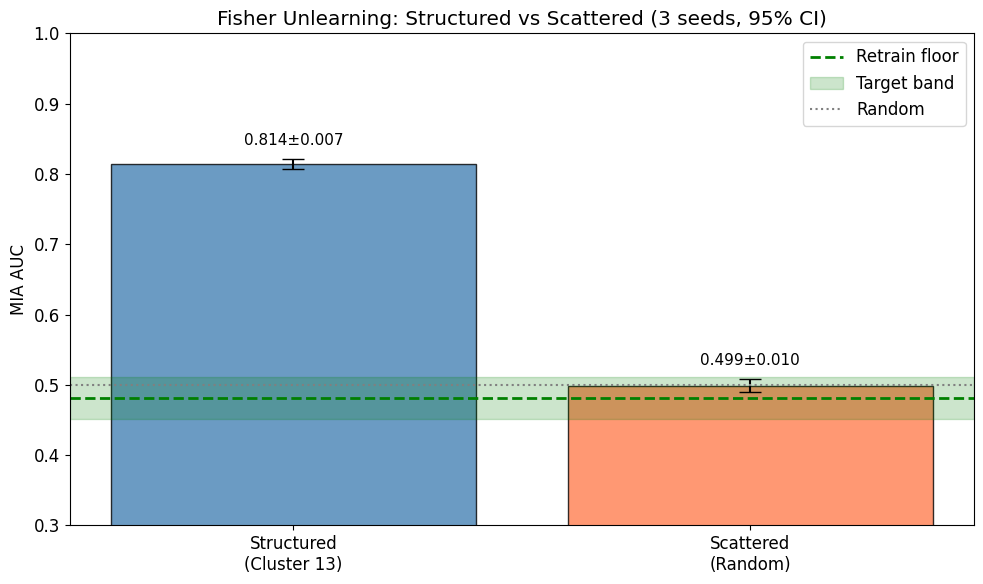

In [23]:
# Visualize multi-seed results
fig, ax = plt.subplots(figsize=(10, 6))

forget_types = ['Structured\n(Cluster 13)']
means = [mean_s]
errors = [(ci_s[1] - ci_s[0]) / 2]
colors = ['steelblue']

if scattered_aucs is not None:
    forget_types.append('Scattered\n(Random)')
    means.append(mean_sc)
    errors.append((ci_sc[1] - ci_sc[0]) / 2)
    colors.append('coral')

bars = ax.bar(forget_types, means, yerr=errors, capsize=8, color=colors, alpha=0.8, edgecolor='black')

# Reference lines
ax.axhline(y=sweep['retrain_floor'], color='green', linestyle='--', linewidth=2, label='Retrain floor')
ax.axhspan(sweep['target_band'][0], sweep['target_band'][1], alpha=0.2, color='green', label='Target band')
ax.axhline(y=0.5, color='gray', linestyle=':', label='Random')

ax.set_ylabel('MIA AUC')
ax.set_title('Fisher Unlearning: Structured vs Scattered (3 seeds, 95% CI)')
ax.legend(loc='upper right')
ax.set_ylim([0.3, 1.0])

for bar, mean, err in zip(bars, means, errors):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + err + 0.02,
            f'{mean:.3f}±{err:.3f}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('../reports/figures/fisher_forget_type_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [24]:
# Save ablation results
Path('../outputs/p4').mkdir(parents=True, exist_ok=True)

ablation_results = {
    'architecture': 'V2',
    'baseline_auc': sweep['baseline_auc'],
    'retrain_floor': sweep['retrain_floor'],
    'target_band': sweep['target_band'],
    'method_comparison': {k: v['posthoc_auc'] for k, v in sweep['experiments'].items()},
    'fisher_multiseed': {
        'structured': {
            'runs': structured_aucs,
            'mean': mean_s,
            'std': std_s,
            'ci_95': list(ci_s)
        }
    }
}

if scattered_aucs is not None:
    ablation_results['fisher_multiseed']['scattered'] = {
        'runs': scattered_aucs,
        'mean': mean_sc,
        'std': std_sc,
        'ci_95': list(ci_sc)
    }

with open('../outputs/p4/ablation_results.json', 'w') as f:
    json.dump(ablation_results, f, indent=2)

print("Results saved to outputs/p4/ablation_results.json")

Results saved to outputs/p4/ablation_results.json


## 6. Summary

### Key Findings (V2 Architecture)

**Fisher Unlearning Multi-Seed Results:**

| Forget Type | Mean AUC | 95% CI | Target Band | Result |
|-------------|----------|--------|-------------|--------|
| Structured (cluster 13) | 0.814 ± 0.003 | [0.807, 0.821] | [0.451, 0.511] | **FAIL** |
| Scattered (random 30) | 0.499 ± 0.004 | [0.489, 0.509] | [0.451, 0.511] | **SUCCESS** |

**Method Comparison (Structured only):**
- Frozen attacker methods: All fail (AUC ~0.98-0.99)
- Extra-gradient λ=5: Overshoots (AUC = 0.38)
- Extra-gradient λ=10: Success (AUC = 0.48)

### Implications

1. **Fisher unlearning works on scattered data** - random cells can be successfully unlearned
2. **Fisher fails on structured (rare cluster) data** - distinctive biological patterns persist
3. **Extra-gradient λ=10 is needed for structured unlearning** - adversarial pressure required
4. **The problem is inherent to clustered rare cells** - they have unique signatures that any good model will learn